Evaluate `gpytorch` on the 1d test example from `hetGP`

In [1]:
from rpy2.robjects import r
import numpy as np
from scipy.stats import norm
r('''
library(hetGP)

X    = seq(from=0, to=1, length.out=200)
reps = sample(1:20,size = length(X), replace = T)
X    = matrix(X[rep(1:length(X),reps)],ncol=1)

Z    = f1d(X) + rnorm(n=nrow(X), sd = 3)
''')
X = np.array(r('X'))
Z = np.array(r('Z')).squeeze()
xgrid = np.linspace(0,1,1000)

In [2]:
# use gpytorch
# source: https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html
# simplest form of GP model, exact inference
import gpytorch
import torch
from time import time
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll_scipy


# initialize likelihood and model

gp = SingleTaskGP(
    torch.from_numpy(X), 
    torch.from_numpy(Z.reshape(-1,1)),
    outcome_transform=None)
# Find optimal model hyperparameters
gp.train()


bounds = {'lengthscale': (0.1,5.0)}
options = {'ftol':1e7*np.finfo(float).eps,'gtol':0}
mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)
fit = fit_gpytorch_mll_scipy(mll,bounds=bounds,options=options)
# "Loss" for GPs - the marginal log likelihood


# eval
gp.eval()

with torch.no_grad():
    X_test         = torch.from_numpy(xgrid)
    posterior      = mll.model(X_test)
    gpytorch_preds = posterior
    
    nugs =  mll.likelihood.noise_covar.noise.item()
    sd2  = posterior.variance.numpy()
    
    gpytorch_lower = norm.ppf(0.05,gpytorch_preds.mean.numpy(),np.sqrt(sd2+ nugs))
    gpytorch_upper = norm.ppf(0.95,gpytorch_preds.mean.numpy(),np.sqrt(sd2+ nugs))

/Users/davidogara/code/HetGPy/releases/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([5.4431], dtype=torch.float64), mean = tensor([0.2582], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


In [3]:
from hetgpy.homGP import homGP
model = homGP()
model.mle(
    X = X,
    Z = Z,
    lower = np.array([0.1]),
    upper = np.array([5]),
    covtype = "Gaussian"
)
preds = model.predict(xgrid)
preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()
preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()
print(f"homGP trained in: {round(model.time,2)} seconds")
print(model.ll)

homGP trained in: 0.08 seconds
-5310.715858189774


In [4]:
# now fit a hetGP to the mcycle data
from hetgpy.example_data import mcycle
from hetgpy import hetGP
m = mcycle()
times, accel = m['times'], m['accel']
het = hetGP()
het.mle(X=times,Z=accel,lower=[0.1],upper=[30])
moto_grid = np.linspace(times.min(),times.max(),500).reshape(-1,1)
moto_preds = het.predict(moto_grid)
moto_preds['upper'] = norm.ppf(0.95, loc = moto_preds['mean'], scale = np.sqrt(moto_preds['sd2'] + moto_preds['nugs'])).squeeze()
moto_preds['lower'] = norm.ppf(0.05, loc = moto_preds['mean'], scale = np.sqrt(moto_preds['sd2'] + moto_preds['nugs'])).squeeze()



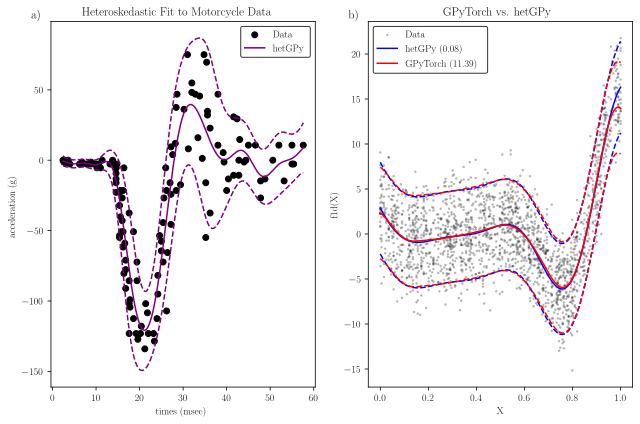

In [5]:
# plot
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
fig, (axa,axb) = plt.subplots(figsize = (9,6),ncols=2)

# Figure 1A
axa.scatter(times,accel,color='k',label = 'Data')
axa.plot(moto_grid, moto_preds['mean'],'purple',label='hetGPy')
axa.plot(moto_grid, moto_preds['upper'],'purple',linestyle='dashed')
axa.plot(moto_grid, moto_preds['lower'],'purple',linestyle='dashed')
axa.set_title('Heteroskedastic Fit to Motorcycle Data')
axa.set_ylabel("acceleration (g)")
axa.set_xlabel("times (msec)")
axa.legend().get_frame().set_edgecolor('black')

# Figure 1B
xs = xgrid.squeeze()
axb.scatter(X.squeeze(), Z,color='k',label = 'Data',alpha=0.2,s=3)
axb.plot(xs, preds['mean'],'b',label=f'hetGPy ({round(model.time,2)})')
axb.plot(xs, preds['upper'],'b',linestyle='dashed')
axb.plot(xs, preds['lower'],'b',linestyle='dashed')
axb.plot(xs,gpytorch_preds.mean.numpy(),'r',label=f'GPyTorch ({round(fit.runtime,2)})')
axb.plot(xs,gpytorch_lower,'r--')
axb.plot(xs,gpytorch_upper,'r--')
axb.legend(markerscale=60)  
axb.legend().get_frame().set_edgecolor('black')
leg = plt.legend()  
plt.legend().get_frame().set_edgecolor('black')
for lh in leg.legend_handles: 
    lh.set_alpha(1)
axb.set_ylabel("f1d(X)")
axb.set_xlabel("X")
axb.set_title("GPyTorch vs. hetGPy")
labels = ['a)','b)']
for i,ax in enumerate([axa,axb]):
    ax.text(
        0.0, 1.0, labels[i], transform=(
            ax.transAxes + ScaledTranslation(-20/72, +0/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')
fig.tight_layout()
fig.savefig('hetGPy-Fig1.svg')